### Deep Learning - Neural Networks
## Project : OCTMNIST Classification
### Deepthi D'Souza



### Dataset: OCTMNIST
The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. Each example is a 28x28 image, associated with a label from 4 classes. 

Getting the data:
MedMNIST is a collection of multiple datasets, for this project we will be working with one dataset from the collection – OCTMNIST

### Steps followed:

1. Download the OCTMNIST 2D dataset and prepare it for training:
- a. Preprocess the dataset by normalizing the pixel values to a standardized
range, typically between 0 and 1.
- b. Split the dataset into three parts: training set, validation set, and test set.
The recommended split ratio is 70% for training, 15% for validation, and
15% for testing. Adjust the split ratio based on the size of the dataset and
your exploration strategies.
2. Build a neural network:
- a. Design a model architecture that consists of at least three layers, including
convolutional layers and fully connected layers. You can build a FC NN or
CNN model.
- b. Ensure appropriate activation functions are applied after each layer to
introduce non-linearity.
3. Apply following techniques to prevent overfitting and discuss each of them and
how they impact the performance:
- a. Regularization: Apply regularization techniques, such as L1 or L2
regularization, to the model's parameters.
- b. Dropout: Introduce dropout layers between the fully connected layers.
- c. Early stopping: Monitor the performance of the model on a validation set
and stop training when the validation loss stops improving.
- d. Expected min accuracy: 70%
4. Save the weights of the trained neural network that provides the best results.
Check saving and loading models (PyTorch)
5. Discuss the results and provide relevant graphs:
- a. Report training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.
- b. Plot the training and validation accuracy over time (epochs).
- c. Plot the training and validation loss over time (epochs).
- d. Generate a confusion matrix using the model's predictions on the test set.
- e. Calculate and report other evaluation metrics such as precision, recall
(scikit-learn), and F1 score (scikit-learn) to further analyze the model's
performance on the test set.

## Step 1: Importing Required Libraries and Imagenet dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

### Importing libraries and Dataset

In [ ]:
import zipfile
import os
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import pickle
import torch
import h5py
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm
import torch.utils.data as data
import torchvision.transforms as transforms


In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=850dce0671976168745cb180ab50910cb51033126622c97a2724596a022a84b6
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from medmnist import OCTMNIST, INFO, Evaluator

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = OCTMNIST(split="train", transform=data_transform, download=True)
val_set = OCTMNIST(split='val', transform=data_transform, download=True)
test_set = OCTMNIST(split='test', transform=data_transform,download=True)


100%|██████████| 54938180/54938180 [00:03<00:00, 16929877.15it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [ ]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=64, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=64, shuffle=False)

In [ ]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'g', label='Training accuracy')
    plt.plot(epochs, test_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss over time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Step 2. Building Base CNN

### CNN network architecture for base model

In [ ]:
class OCTNet_base(nn.Module):
    def __init__(self):
        super(OCTNet_base, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Adjusted input size for fc1
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

mod = OCTNet_base()
print(mod)

OCTNet_base(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


### Train validate and test for base model

Epoch [1/10], Train Loss: 0.5652, Train Accuracy: 79.59%, Val Loss: 0.4272, Val Accuracy: 84.92%
Epoch [2/10], Train Loss: 0.3859, Train Accuracy: 86.45%, Val Loss: 0.3504, Val Accuracy: 87.67%
Epoch [3/10], Train Loss: 0.3255, Train Accuracy: 88.60%, Val Loss: 0.3277, Val Accuracy: 88.69%
Epoch [4/10], Train Loss: 0.2793, Train Accuracy: 90.17%, Val Loss: 0.3064, Val Accuracy: 89.63%
Epoch [5/10], Train Loss: 0.2399, Train Accuracy: 91.68%, Val Loss: 0.2938, Val Accuracy: 89.84%
Epoch [6/10], Train Loss: 0.2059, Train Accuracy: 92.94%, Val Loss: 0.2882, Val Accuracy: 90.61%
Epoch [7/10], Train Loss: 0.1792, Train Accuracy: 93.79%, Val Loss: 0.2645, Val Accuracy: 91.33%
Epoch [8/10], Train Loss: 0.1549, Train Accuracy: 94.63%, Val Loss: 0.2815, Val Accuracy: 90.81%
Epoch [9/10], Train Loss: 0.1331, Train Accuracy: 95.40%, Val Loss: 0.2846, Val Accuracy: 91.57%
Epoch [10/10], Train Loss: 0.1164, Train Accuracy: 96.03%, Val Loss: 0.2966, Val Accuracy: 91.31%
Test Accuracy: 69.90%
Confusi

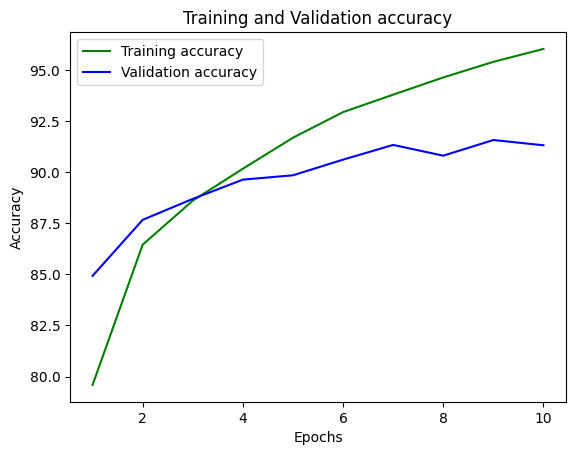

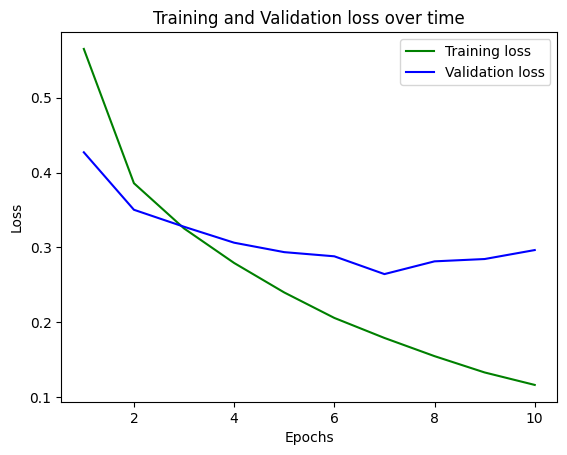

In [ ]:
def train_val_test_base(model_base, train_loader, val_loader, test_loader):
    # Define the hyperparameters
    learning_rate = 0.001
    num_epochs = 10

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_base.parameters(), lr=learning_rate)

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # Training loop
    for epoch in range(num_epochs):
        model_base.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # print(labels.shape)

            labels = torch.squeeze(labels)

            optimizer.zero_grad()

            outputs = model_base(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation loop
        model_base.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.squeeze(labels)

                outputs = model_base(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print the training and validation loss, and accuracy for each epoch
        train_loss /= len(train_loader)
        train_accuracy = 100.0 * train_correct / train_total
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Test the model
    model_base.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.squeeze(labels)

            outputs = model_base(images)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the test accuracy
    test_accuracy = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1 score
    report = classification_report(all_labels, all_predictions)
    print("Classification Report:")
    print(report)

    plot_accuracy(train_acc_list,val_acc_list)
    plot_loss(train_loss_list,val_loss_list)

    return model_base.state_dict()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the OCTNet model
model_base = OCTNet_base()
model_base.to(device)
model_weights = train_val_test_base(model_base, train_loader, val_loader, test_loader)

# Save weights to a pickle file
pickle_out = open("model_base.pickle", "wb")
pickle.dump(model_weights, pickle_out)
pickle_out.close()


## Step 3: Applying Various Transformations on the Base Model

### 1. Regularization


Epoch [1/10], Train Loss: 0.5815, Train Accuracy: 79.35%, Val Loss: 0.4327, Val Accuracy: 85.04%
Epoch [2/10], Train Loss: 0.3970, Train Accuracy: 86.01%, Val Loss: 0.3883, Val Accuracy: 86.60%
Epoch [3/10], Train Loss: 0.3380, Train Accuracy: 88.14%, Val Loss: 0.3389, Val Accuracy: 88.10%
Epoch [4/10], Train Loss: 0.2917, Train Accuracy: 89.82%, Val Loss: 0.3283, Val Accuracy: 88.87%
Epoch [5/10], Train Loss: 0.2549, Train Accuracy: 91.14%, Val Loss: 0.2914, Val Accuracy: 89.87%
Epoch [6/10], Train Loss: 0.2202, Train Accuracy: 92.33%, Val Loss: 0.2847, Val Accuracy: 90.06%
Epoch [7/10], Train Loss: 0.1921, Train Accuracy: 93.32%, Val Loss: 0.2988, Val Accuracy: 89.99%
Epoch [8/10], Train Loss: 0.1672, Train Accuracy: 94.14%, Val Loss: 0.3075, Val Accuracy: 90.49%
Epoch [9/10], Train Loss: 0.1441, Train Accuracy: 95.00%, Val Loss: 0.3128, Val Accuracy: 90.67%
Epoch [10/10], Train Loss: 0.1235, Train Accuracy: 95.71%, Val Loss: 0.3255, Val Accuracy: 90.25%
Test Accuracy: 70.00%
Confusi

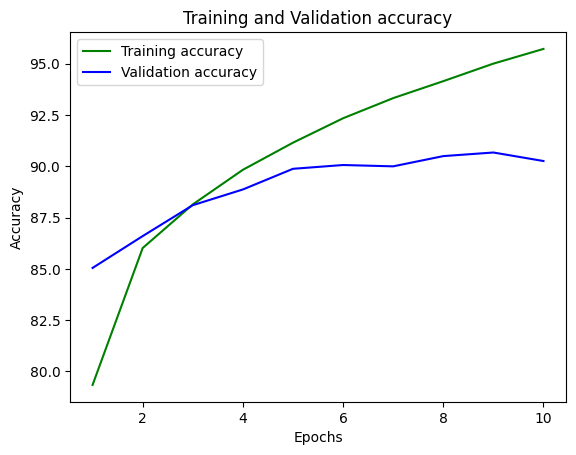

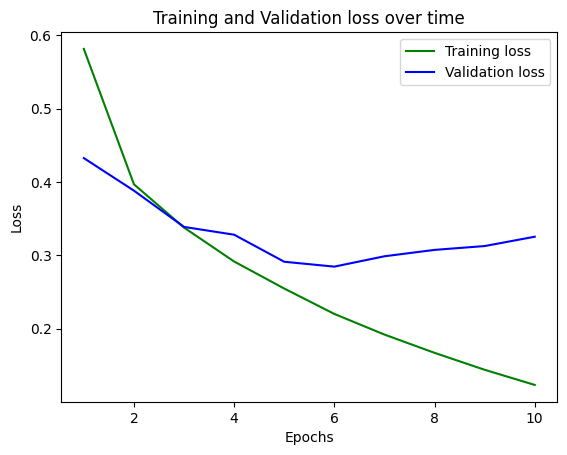

In [ ]:
def train_val_test_reg(model_reg, train_loader,val_loader,test_loader):

  # Define the hyperparameters
  learning_rate = 0.0001
  num_epochs = 10

  # Define the loss function
  criterion = nn.CrossEntropyLoss()
  # Define the regularization strength
  weight_decay = 1e-5
  # Define the optimizer with L2 regularization
  optimizer = optim.Adam(model_reg.parameters(), lr=learning_rate, weight_decay=weight_decay)

  train_acc_list = []
  val_acc_list = []
  train_loss_list = []
  val_loss_list = []
  train_total = 0
  val_total = 0


  # Training loop
  for epoch in range(num_epochs):
      model_reg.train()  # Set the model to training mode

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)
          labels = torch.squeeze(labels)

          optimizer.zero_grad()

          outputs = model_reg(images)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

      # Validation loop
      model_reg.eval()  # Set the model to evaluation mode
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              labels = torch.squeeze(labels)

              outputs = model_reg(images)
              val_loss += criterion(outputs, labels).item()

              _, predicted = torch.max(outputs, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      # Print the training and validation loss, and accuracy for each epoch
      train_loss = loss.item()
      train_accuracy = 100.0 * (predicted == labels).sum().item() / labels.size(0)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      val_loss /= len(val_loader)
      val_accuracy = 100.0 * val_correct / val_total
      val_loss_list.append(val_loss)
      val_acc_list.append(val_accuracy)

      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  # Test the model
  model_reg.eval()  # Set the model to evaluation mode
  test_correct = 0
  test_total = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          labels = torch.squeeze(labels)

          outputs = model_reg(images)

          _, predicted = torch.max(outputs, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()

          all_predictions.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate the test accuracy
  test_accuracy = 100.0 * test_correct / test_total
  print(f"Test Accuracy: {test_accuracy:.2f}%")

  # Generate confusion matrix
  cm = confusion_matrix(all_labels, all_predictions)
  print("Confusion Matrix:")
  print(cm)

  # Calculate precision, recall, and F1 score
  report = classification_report(all_labels, all_predictions)
  print("Classification Report:")
  print(report)
  plot_accuracy(train_acc_list,val_acc_list)
  plot_loss(train_loss_list,val_loss_list)

  return model_reg.state_dict()


# Create an instance of the AlexNet model
model_base = OCTNet_base().to(device)
model_reg_weights = train_val_test_base(model_base,train_loader,val_loader,test_loader)

# save weights in pickle file
pickle_out = open("model_reg.pickle", "wb")
pickle.dump(model_reg_weights, pickle_out)
pickle_out.close()


### 2. DropOut Method

In [ ]:

import torch
import torch.nn as nn

class OCTNet_dropout(nn.Module):
    def __init__(self):
        super(OCTNet_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 12 * 12, 1024)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.7)  # Increased dropout rate
        self.fc2 = nn.Linear(1024, 256)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.7)  # Increased dropout rate
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)  # Applied dropout
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

mod = OCTNet_dropout().to(device)


Epoch [1/15], Train Loss: 0.6909, Train Accuracy: 75.30%, Val Loss: 0.4688, Val Accuracy: 83.93%
Epoch [2/15], Train Loss: 0.4650, Train Accuracy: 84.22%, Val Loss: 0.4341, Val Accuracy: 84.96%
Epoch [3/15], Train Loss: 0.4028, Train Accuracy: 86.31%, Val Loss: 0.3745, Val Accuracy: 87.44%
Epoch [4/15], Train Loss: 0.3583, Train Accuracy: 87.76%, Val Loss: 0.3258, Val Accuracy: 88.64%
Epoch [5/15], Train Loss: 0.3252, Train Accuracy: 88.87%, Val Loss: 0.3020, Val Accuracy: 89.56%
Epoch [6/15], Train Loss: 0.2931, Train Accuracy: 90.05%, Val Loss: 0.2877, Val Accuracy: 90.11%
Epoch [7/15], Train Loss: 0.2713, Train Accuracy: 90.77%, Val Loss: 0.2762, Val Accuracy: 90.53%
Epoch [8/15], Train Loss: 0.2471, Train Accuracy: 91.62%, Val Loss: 0.2800, Val Accuracy: 90.79%
Epoch [9/15], Train Loss: 0.2306, Train Accuracy: 92.25%, Val Loss: 0.2626, Val Accuracy: 91.36%
Epoch [10/15], Train Loss: 0.2141, Train Accuracy: 92.71%, Val Loss: 0.2598, Val Accuracy: 91.63%
Epoch [11/15], Train Loss: 0.

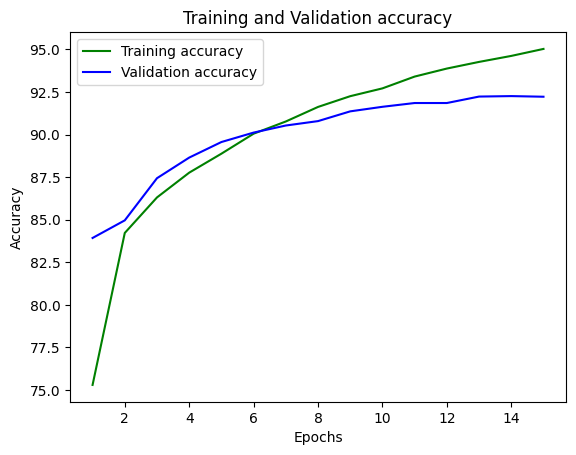

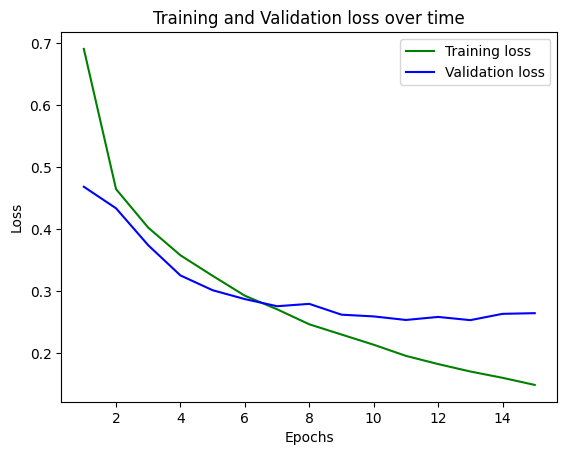

In [ ]:
def train_val_test_dp(model_base, train_loader, val_loader, test_loader):
    # Define the hyperparameters
    learning_rate = 0.0005
    num_epochs = 15

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_base.parameters(), lr=learning_rate)

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # Training loop
    for epoch in range(num_epochs):
        model_base.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # print(labels.shape)

            labels = torch.squeeze(labels)

            optimizer.zero_grad()

            outputs = model_base(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation loop
        model_base.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.squeeze(labels)

                outputs = model_base(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print the training and validation loss, and accuracy for each epoch
        train_loss /= len(train_loader)
        train_accuracy = 100.0 * train_correct / train_total
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Test the model
    model_base.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.squeeze(labels)

            outputs = model_base(images)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the test accuracy
    test_accuracy = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")



    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1 score
    report = classification_report(all_labels, all_predictions)
    print("Classification Report:")
    print(report)

    plot_accuracy(train_acc_list,val_acc_list)
    plot_loss(train_loss_list,val_loss_list)

    return model_base.state_dict()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the AlexNet model
model_dropout = OCTNet_dropout().to(device)
model_dropout_weights = train_val_test_dp(model_dropout,train_loader,val_loader,test_loader)

# save weights in pickle file
pickle_out = open("model_dropout.pickle", "wb")
pickle.dump(model_dropout_weights, pickle_out)
pickle_out.close()


### 3. Early stopping

Epoch [1/20], Train Loss: 0.7443, Train Accuracy: 75.00%, Val Loss: 0.6399, Val Accuracy: 77.53%
Epoch [2/20], Train Loss: 0.0943, Train Accuracy: 87.50%, Val Loss: 0.5309, Val Accuracy: 81.33%
Epoch [3/20], Train Loss: 1.3118, Train Accuracy: 81.25%, Val Loss: 0.5102, Val Accuracy: 82.08%
Epoch [4/20], Train Loss: 0.3751, Train Accuracy: 87.50%, Val Loss: 0.4783, Val Accuracy: 83.27%
Epoch [5/20], Train Loss: 0.4172, Train Accuracy: 87.50%, Val Loss: 0.4389, Val Accuracy: 84.78%
Epoch [6/20], Train Loss: 0.4379, Train Accuracy: 87.50%, Val Loss: 0.4367, Val Accuracy: 84.59%
Epoch [7/20], Train Loss: 0.5555, Train Accuracy: 75.00%, Val Loss: 0.4272, Val Accuracy: 84.97%
Epoch [8/20], Train Loss: 0.0663, Train Accuracy: 87.50%, Val Loss: 0.4050, Val Accuracy: 85.72%
Epoch [9/20], Train Loss: 0.2214, Train Accuracy: 100.00%, Val Loss: 0.3902, Val Accuracy: 86.30%
Epoch [10/20], Train Loss: 0.0907, Train Accuracy: 87.50%, Val Loss: 0.3755, Val Accuracy: 87.12%
Epoch [11/20], Train Loss: 0

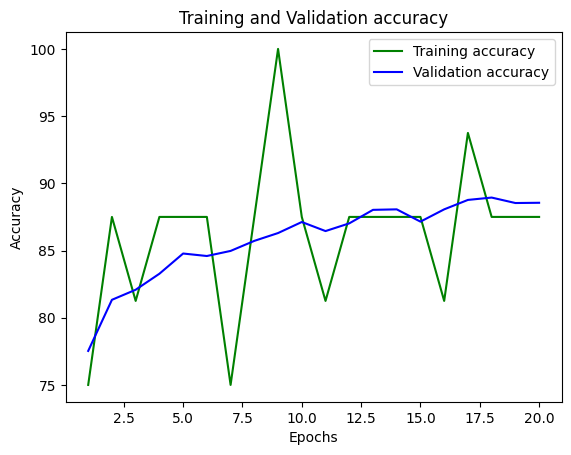

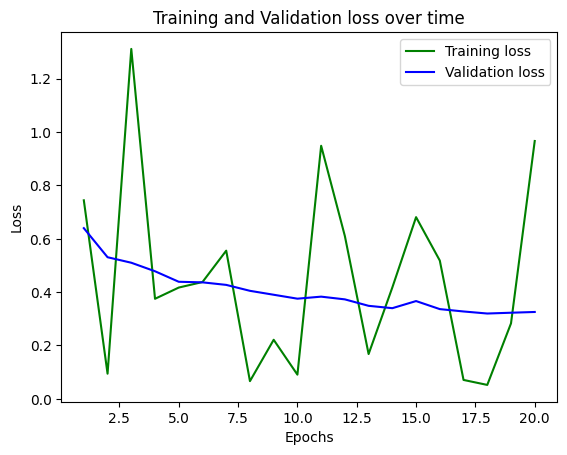

In [ ]:
def train_val_test_es(model, train_loader, val_loader, test_loader, patience=5):
    # Define the hyperparameters
    learning_rate = 0.0001
    num_epochs = 20

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    best_model_state_dict = None
    early_stopping_counter = 0
    train_total = 0
    val_total = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.squeeze(labels)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.squeeze(labels)

                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print the training and validation loss, and accuracy for each epoch
        train_loss = loss.item()
        train_accuracy = 100.0 * (predicted == labels).sum().item() / labels.size(0)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Stop training if validation loss hasn't improved for 'patience' epochs
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    # Load the best model
    model.load_state_dict(best_model_state_dict)

    # Test the model
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.squeeze(labels)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the test accuracy
    test_accuracy = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1 score
    report = classification_report(all_labels, all_predictions)
    print("Classification Report:")
    print(report)
    plot_accuracy(train_acc_list,val_acc_list)
    plot_loss(train_loss_list,val_loss_list)

    return model.state_dict()

# Create an instance of the AlexNet model
model_base = OCTNet_base().to(device)
model_es_weights = train_val_test_es(model_base, train_loader, val_loader, test_loader, patience=5)

# save weights in pickle file
pickle_out = open("model_es.pickle", "wb")
pickle.dump(model_es_weights, pickle_out)
pickle_out.close()


### 4. Image augmentation

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Epoch [1/15], Train Loss: 0.7791, Train Accuracy: 71.88%, Val Loss: 0.6012, Val Accuracy: 78.25%
Epoch [2/15], Train Loss: 0.6030, Train Accuracy: 79.13%, Val Loss: 0.5101, Val Accuracy: 82.27%
Epoch [3/15], Train Loss: 0.5494, Train Accuracy: 81.10%, Val Loss: 0.4820, Val Accuracy: 83.11%
Epoch [4/15], Train Loss: 0.5204, Train Accuracy: 82.17%, Val Loss: 0.4549, Val Accuracy: 83.97%
Epoch [5/15], Train Loss: 0.5002, Train Accuracy: 82.86%, Val Loss: 0.4397, Val Accuracy: 84.51%
Epoch [6/15], Train Loss: 0.4837, Train Accuracy: 83.43%, Val Loss: 0.4207, Val Accuracy: 85.08%
Epoch [7/15], Train Loss: 0.4721, Train Accuracy: 83.72%, Val Loss: 0.4127, Val Accuracy: 85.67%
Epoch [8/15], Train Loss: 0.4611, Train Accuracy: 84.05%, Val Loss: 0.4072, Val Accuracy: 85.51%
Epoch [9/15], Train Loss: 0.4535, Train Accuracy: 84.31%, Val Loss: 0.4018, Val Accuracy: 85.88%
Epoch [10/15], Train Loss: 0.4460, Train Accuracy: 84.56%, Val

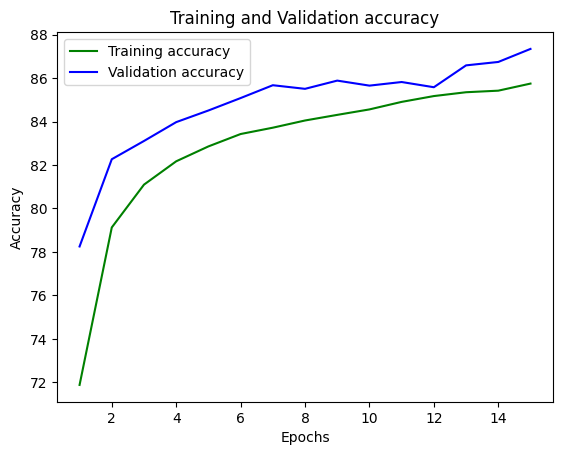

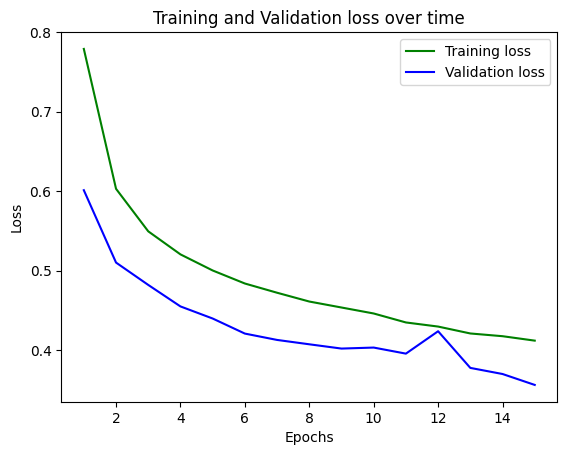

In [ ]:
import torchvision.transforms as transforms

# Define data transformations including augmentation
data_transform = transforms.Compose([
    transforms.RandomRotation(10),            # Random rotation by 10 degrees
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomVerticalFlip(),          # Random vertical flip
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the train, validation, and test datasets with image augmentation
train_set = OCTMNIST(split="train", transform=data_transform, download=True)

# Encapsulate data into dataloader form
train_loader_aug = data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)


# Use train_loader_augmented for training instead of train_loader in the train_val_test_base function
model_dp = OCTNet_dropout().to(device)
model_aug = train_val_test_dp(model_dp, train_loader_aug, val_loader, test_loader)

# save weights in pickle file
pickle_out = open("model_aug.pickle", "wb")
pickle.dump(model_aug, pickle_out)
pickle_out.close()

## References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

2. https://matplotlib.org/
